In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
import torchaudio.transforms as T
from torchvision.models import resnet50
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')

In [4]:
data_dir = '//kaggle/input/heartbeat-sounds/set_b'
file_csv = '/kaggle/input/heartbeat-sounds/set_b.csv'

In [5]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [6]:
NUM_SAMPLES = 65500
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 15
train_size = 0.8

In [7]:
recordings_old = sorted(os.listdir(data_dir))

In [8]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [9]:
len(recordings)

638

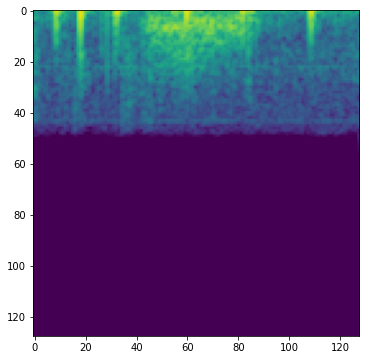

In [10]:
y, _ = librosa.load(data_dir + '/' + recordings[200], sr = sr)
begin = (len(y) - NUM_SAMPLES) // 2
samples = y[begin:begin + NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels = nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [11]:
image_size = melspec.shape
image_size

(128, 128)

In [12]:
melspec = torch.tensor(melspec)
melspec = torch.stack([melspec, melspec, melspec])

In [13]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 12):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 12):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(12)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 12)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [14]:
def get_spectrograms(filename):
    y, _ = librosa.load(filename, sr = sr)
    count = len(y) // NUM_SAMPLES
    mel_spectrograms = []
    for i in range(count):
        samples = y[i * NUM_SAMPLES:(i + 1) * NUM_SAMPLES]
        melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
        melspec = librosa.power_to_db(melspec)
        melspec = normalize(melspec, mean=None, std=None)
        mel_spectrograms.append(torch.tensor(melspec, dtype=torch.float32))

    return mel_spectrograms, count

In [15]:
class HeartbeatSounds(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
data = []
labels = []
for i in range(len(recordings)):
    if 'normal' in recordings[i]:
        label = 0
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'extrastole' in recordings[i]:
        label = 1
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'murmur' in recordings[i]:
        label = 2
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)

In [17]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [18]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [19]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet50

### No Augmentation

In [20]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = False, aug_type = 'No', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch: 0
Train
0.8179877072312323
TEST
loss: 0.9778176487438263
accuracy: 0.7111111111111111
******************
epoch: 1
Train
0.6205184720308654
TEST
loss: 0.7682190365261502
accuracy: 0.6857142857142857
******************
epoch: 2
Train
0.5377828446146606
TEST
loss: 0.7380135977078998
accuracy: 0.6888888888888889
******************
epoch: 3
Train
0.4926887943310999
TEST
loss: 0.6973121680910626
accuracy: 0.7619047619047619
******************
epoch: 4
Train
0.45774495514069785
TEST
loss: 1.0381238748156836
accuracy: 0.6285714285714286
******************
epoch: 5
Train
0.43508150365212495
TEST
loss: 0.5910969794742644
accuracy: 0.7587301587301587
******************
epoch: 6
Train
0.36718996353240313
TEST
loss: 0.6197395525281392
accuracy: 0.7873015873015873
******************
epoch: 7
Train
0.36920679969575504
TEST
loss: 0.7008441072607797
accuracy: 0.7587301587301587
******************
epoch: 8
Train
0.2909877990757879
TEST
loss: 0.7593888725553241
accuracy: 0.7142857142857143
*******

In [21]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8527918781725888


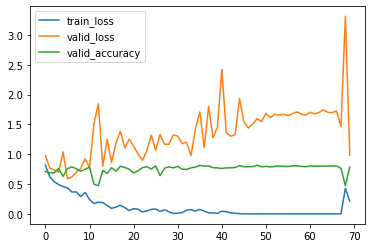

In [22]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [23]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.8592178771853731
TEST
loss: 0.9626436623315963
accuracy: 0.7428571428571429
******************
epoch: 1
Train
0.5961578986870096
TEST
loss: 0.6614252323196048
accuracy: 0.7238095238095238
******************
epoch: 2
Train
0.5743227368124522
TEST
loss: 0.6710954862927634
accuracy: 0.726984126984127
******************
epoch: 3
Train
0.5273787985253278
TEST
loss: 0.5801582465096126
accuracy: 0.7968253968253968
******************
epoch: 4
Train
0.505037667071469
TEST
loss: 1.0956826018908667
accuracy: 0.4793650793650794
******************
epoch: 5
Train
0.46442628356556365
TEST
loss: 0.9953858612075684
accuracy: 0.5619047619047619
******************
epoch: 6
Train
0.4238937491931264
TEST
loss: 0.7669191332090468
accuracy: 0.7492063492063492
******************
epoch: 7
Train
0.3905886078373225
TEST
loss: 0.6391255953955272
accuracy: 0.7682539682539683
******************
epoch: 8
Train
0.3475217671977612
TEST
loss: 0.9321767403965905
accuracy: 0

In [24]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8197969543147208


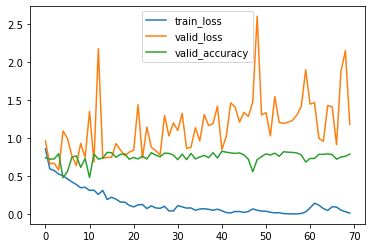

In [25]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [26]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.8589162134622372
TEST
loss: 0.9463161824241517
accuracy: 0.6888888888888889
******************
epoch: 1
Train
0.5777101454704503
TEST
loss: 0.596186872134133
accuracy: 0.7777777777777778
******************
epoch: 2
Train
0.5646357582948622
TEST
loss: 0.9671310142865257
accuracy: 0.780952380952381
******************
epoch: 3
Train
0.5151016451329632
TEST
loss: 1.5922898837498256
accuracy: 0.49206349206349204
******************
epoch: 4
Train
0.4979059475579841
TEST
loss: 0.5782786918064905
accuracy: 0.7873015873015873
******************
epoch: 5
Train
0.47868030505865883
TEST
loss: 0.94313645362854
accuracy: 0.7396825396825397
******************
epoch: 6
Train
0.47872796404967716
TEST
loss: 0.5722427814725846
accuracy: 0.7714285714285715
******************
epoch: 7
Train
0.39811298629894815
TEST
loss: 1.5822321543617854
accuracy: 0.765079365079365
******************
epoch: 8
Train
0.37749043192249904
TEST
loss: 0.802580211843763
accuracy: 0

In [27]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8350253807106599


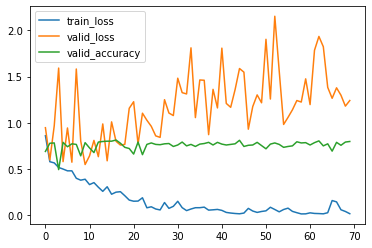

In [28]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [29]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.7881259199785182
TEST
loss: 0.775971826106783
accuracy: 0.6761904761904762
******************
epoch: 1
Train
0.5710221194056313
TEST
loss: 1.123542186570546
accuracy: 0.5492063492063493
******************
epoch: 2
Train
0.5412405830607516
TEST
loss: 0.6704447452984159
accuracy: 0.7555555555555555
******************
epoch: 3
Train
0.5127776318168337
TEST
loss: 1.3858234471744961
accuracy: 0.6476190476190476
******************
epoch: 4
Train
0.5204161631862164
TEST
loss: 1.0990828459225004
accuracy: 0.746031746031746
******************
epoch: 5
Train
0.44198811873260996
TEST
loss: 0.6009941288403102
accuracy: 0.7904761904761904
******************
epoch: 6
Train
0.3805368038943308
TEST
loss: 0.551934202985158
accuracy: 0.7841269841269841
******************
epoch: 7
Train
0.4017225776142881
TEST
loss: 0.9171683555557615
accuracy: 0.7777777777777778
******************
epoch: 8
Train
0.3427527278093614
TEST
loss: 1.1619083222888764
accuracy: 0.7

In [30]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8375634517766497


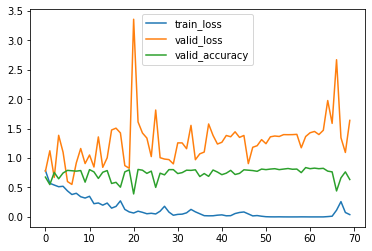

In [31]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [32]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.8385961058122757
TEST
loss: 4.427743858761257
accuracy: 0.5111111111111111
******************
epoch: 1
Train
0.6302431747731564
TEST
loss: 0.6275682956453353
accuracy: 0.7714285714285715
******************
epoch: 2
Train
0.5549773163412941
TEST
loss: 0.669316405909402
accuracy: 0.7714285714285715
******************
epoch: 3
Train
0.4983097159076627
TEST
loss: 0.8862720065646701
accuracy: 0.6317460317460317
******************
epoch: 4
Train
0.46535535915395965
TEST
loss: 0.9624689204352243
accuracy: 0.5841269841269842
******************
epoch: 5
Train
0.45585830897873975
TEST
loss: 0.9067730394620744
accuracy: 0.7873015873015873
******************
epoch: 6
Train
0.38035753428509916
TEST
loss: 1.7365853271787128
accuracy: 0.580952380952381
******************
epoch: 7
Train
0.40101560385715784
TEST
loss: 1.2743350679912264
accuracy: 0.5333333333333333
******************
epoch: 8
Train
0.32504449861687834
TEST
loss: 0.7797301218623207
accuracy

In [33]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8350253807106599


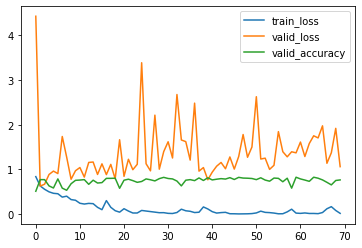

In [34]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [35]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.870205347361879
TEST
loss: 1.3693656830560594
accuracy: 0.7746031746031746
******************
epoch: 1
Train
0.6982909543728242
TEST
loss: 0.6632013110887437
accuracy: 0.7428571428571429
******************
epoch: 2
Train
0.6306127528049721
TEST
loss: 1.007200902984256
accuracy: 0.5619047619047619
******************
epoch: 3
Train
0.6249130612995247
TEST
loss: 1.4520551692871821
accuracy: 0.44126984126984126
******************
epoch: 4
Train
0.5739548028320239
TEST
loss: 0.6082129512514387
accuracy: 0.7873015873015873
******************
epoch: 5
Train
0.5629726507249003
TEST
loss: 0.49844710637652684
accuracy: 0.8158730158730159
******************
epoch: 6
Train
0.5105806734942556
TEST
loss: 0.7691340484316387
accuracy: 0.6412698412698413
******************
epoch: 7
Train
0.5273840151389881
TEST
loss: 0.6343357833604965
accuracy: 0.7714285714285715
******************
epoch: 8
Train
0.49833196077297565
TEST
loss: 0.5477115518516964
accuracy:

In [36]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8629441624365483


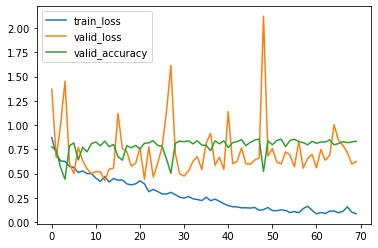

In [37]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [38]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
1.0158976264848323
TEST
loss: 98.15923321436323
accuracy: 0.09523809523809523
******************
epoch: 1
Train
0.7151758717913018
TEST
loss: 0.7210578422697763
accuracy: 0.7238095238095238
******************
epoch: 2
Train
0.6718581478400681
TEST
loss: 0.720771044398111
accuracy: 0.7174603174603175
******************
epoch: 3
Train
0.6092257449511406
TEST
loss: 0.9388049280832684
accuracy: 0.580952380952381
******************
epoch: 4
Train
0.6342270510645496
TEST
loss: 0.6763973612633962
accuracy: 0.7333333333333333
******************
epoch: 5
Train
0.6354845707098391
TEST
loss: 0.5997482523085579
accuracy: 0.7873015873015873
******************
epoch: 6
Train
0.603647719213563
TEST
loss: 0.6654369276667398
accuracy: 0.7238095238095238
******************
epoch: 7
Train
0.6208955202905596
TEST
loss: 0.5957099042241536
accuracy: 0.7936507936507936
******************
epoch: 8
Train
0.5651500653993335
TEST
loss: 0.6235869301689996
accuracy: 0.7

In [39]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8274111675126904


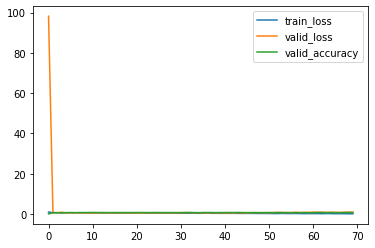

In [40]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [41]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.927003463669558
TEST
loss: 5.9889583148653545
accuracy: 0.26031746031746034
******************
epoch: 1
Train
0.7406556562974019
TEST
loss: 1.032206564100962
accuracy: 0.7111111111111111
******************
epoch: 2
Train
0.6462270308336253
TEST
loss: 2.395333046383328
accuracy: 0.3396825396825397
******************
epoch: 3
Train
0.6196375952721399
TEST
loss: 0.9489830308490329
accuracy: 0.7142857142857143
******************
epoch: 4
Train
0.6309080740778668
TEST
loss: 0.7168694142311338
accuracy: 0.7142857142857143
******************
epoch: 5
Train
0.6208908466046722
TEST
loss: 0.7314872575184656
accuracy: 0.6857142857142857
******************
epoch: 6
Train
0.5836444843658102
TEST
loss: 0.7717526441528684
accuracy: 0.726984126984127
******************
epoch: 7
Train
0.6089028743546193
TEST
loss: 1.1277904349660117
accuracy: 0.6507936507936508
******************
epoch: 8
Train
0.6026304868169017
TEST
loss: 1.0931865160427396
accuracy: 0.5

In [42]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8071065989847716


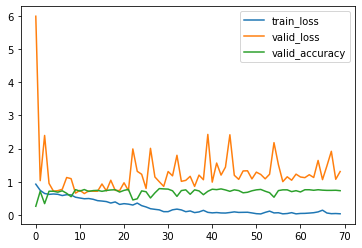

In [43]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [44]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.8738547333940047
TEST
loss: 1.3023982562716045
accuracy: 0.7523809523809524
******************
epoch: 1
Train
0.6111035379296357
TEST
loss: 1.1919286086445764
accuracy: 0.7301587301587301
******************
epoch: 2
Train
0.5403643047364578
TEST
loss: 0.6104515312209962
accuracy: 0.7841269841269841
******************
epoch: 3
Train
0.5517149874385715
TEST
loss: 1.1165436434367346
accuracy: 0.6444444444444445
******************
epoch: 4
Train
0.4765883752332025
TEST
loss: 0.6315811152496035
accuracy: 0.7587301587301587
******************
epoch: 5
Train
0.46238835829415903
TEST
loss: 0.503840243343323
accuracy: 0.8158730158730159
******************
epoch: 6
Train
0.44885960074527764
TEST
loss: 0.6072748108515664
accuracy: 0.7714285714285715
******************
epoch: 7
Train
0.4194664506684039
TEST
loss: 1.6438304761099436
accuracy: 0.38095238095238093
******************
epoch: 8
Train
0.35348439124295217
TEST
loss: 1.1163193948685177
accurac

In [45]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8299492385786802


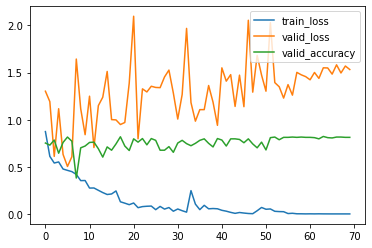

In [46]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [47]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.8486870619586009
TEST
loss: 0.7475062154588246
accuracy: 0.7365079365079366
******************
epoch: 1
Train
0.571154562784529
TEST
loss: 0.6723843400440519
accuracy: 0.7587301587301587
******************
epoch: 2
Train
0.5115283555081196
TEST
loss: 0.6630872325291709
accuracy: 0.7047619047619048
******************
epoch: 3
Train
0.4935250477813557
TEST
loss: 0.7881576965725611
accuracy: 0.6063492063492063
******************
epoch: 4
Train
0.4623245470480279
TEST
loss: 0.7391792798799182
accuracy: 0.6888888888888889
******************
epoch: 5
Train
0.410555417903176
TEST
loss: 0.8675391889753796
accuracy: 0.7968253968253968
******************
epoch: 6
Train
0.498469961858913
TEST
loss: 0.6404503412662991
accuracy: 0.7777777777777778
******************
epoch: 7
Train
0.41354666406479595
TEST
loss: 0.5889131148656209
accuracy: 0.7619047619047619
******************
epoch: 8
Train
0.2993422825484166
TEST
loss: 1.2779895937632
accuracy: 0.587

In [48]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8451776649746193


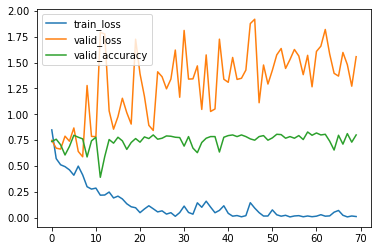

In [49]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [50]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.9480101082701831
TEST
loss: 1.4304930872387356
accuracy: 0.3047619047619048
******************
epoch: 1
Train
0.6871759758239895
TEST
loss: 0.7420840645593311
accuracy: 0.707936507936508
******************
epoch: 2
Train
0.6301981971508175
TEST
loss: 0.8570721495719184
accuracy: 0.638095238095238
******************
epoch: 3
Train
0.601369126909209
TEST
loss: 0.6711958118847439
accuracy: 0.7174603174603175
******************
epoch: 4
Train
0.5674672692043616
TEST
loss: 0.6299134029282464
accuracy: 0.7428571428571429
******************
epoch: 5
Train
0.5530814278258323
TEST
loss: 0.5819253085151551
accuracy: 0.7841269841269841
******************
epoch: 6
Train
0.5011508371547824
TEST
loss: 0.6573682489849272
accuracy: 0.7492063492063492
******************
epoch: 7
Train
0.5142981671359067
TEST
loss: 0.9722272189836654
accuracy: 0.7142857142857143
******************
epoch: 8
Train
0.4976563674291985
TEST
loss: 0.91646268311001
accuracy: 0.733

In [51]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8654822335025381


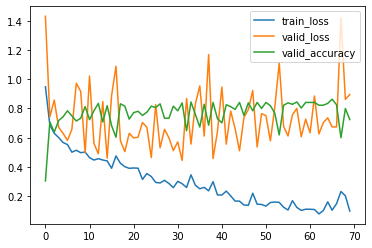

In [52]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [53]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.9826058036661792
TEST
loss: 1.188771146819705
accuracy: 0.5936507936507937
******************
epoch: 1
Train
0.7323837241689017
TEST
loss: 1.1655934125658065
accuracy: 0.6984126984126984
******************
epoch: 2
Train
0.7351360681797419
TEST
loss: 5.066246831984747
accuracy: 0.48253968253968255
******************
epoch: 3
Train
0.6783425857189442
TEST
loss: 0.6673410256703695
accuracy: 0.7333333333333333
******************
epoch: 4
Train
0.6459150976657488
TEST
loss: 0.6530850970555866
accuracy: 0.7396825396825397
******************
epoch: 5
Train
0.6444310989523805
TEST
loss: 0.67064070852976
accuracy: 0.7523809523809524
******************
epoch: 6
Train
0.6095110584195405
TEST
loss: 0.6865016492586288
accuracy: 0.7714285714285715
******************
epoch: 7
Train
0.6155067605334108
TEST
loss: 0.7278802065622239
accuracy: 0.7206349206349206
******************
epoch: 8
Train
0.6192732937663581
TEST
loss: 0.6883562477808151
accuracy: 0.7

In [54]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8350253807106599


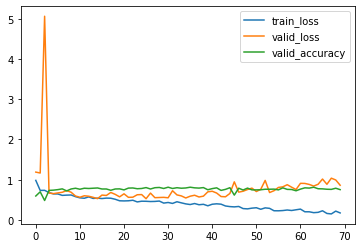

In [55]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [56]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.8301801566002007
TEST
loss: 1.8662026344783722
accuracy: 0.4793650793650794
******************
epoch: 1
Train
0.638692656758288
TEST
loss: 0.9628336242267064
accuracy: 0.6793650793650794
******************
epoch: 2
Train
0.5582490508948365
TEST
loss: 0.8228022908407544
accuracy: 0.6698412698412698
******************
epoch: 3
Train
0.5560428697595149
TEST
loss: 0.6659568364658053
accuracy: 0.7523809523809524
******************
epoch: 4
Train
0.5304417892805255
TEST
loss: 0.590631319795336
accuracy: 0.7936507936507936
******************
epoch: 5
Train
0.5643890212224153
TEST
loss: 0.6405359561481173
accuracy: 0.7841269841269841
******************
epoch: 6
Train
0.5265532991448691
TEST
loss: 0.6418466094940428
accuracy: 0.7523809523809524
******************
epoch: 7
Train
0.5043800411194066
TEST
loss: 0.5390268410955157
accuracy: 0.8095238095238095
******************
epoch: 8
Train
0.4972486054973057
TEST
loss: 1.0081705710244557
accuracy: 0.

In [57]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.868020304568528


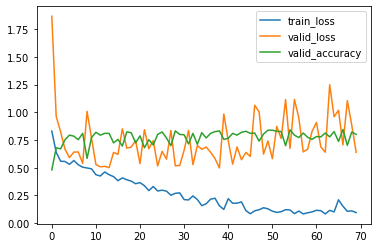

In [58]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [59]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.9885360358062484
TEST
loss: 0.7630402231973316
accuracy: 0.7142857142857143
******************
epoch: 1
Train
0.7606473908810695
TEST
loss: 0.8336214196114313
accuracy: 0.7523809523809524
******************
epoch: 2
Train
0.7124691364592839
TEST
loss: 1.4079668904107714
accuracy: 0.7619047619047619
******************
epoch: 3
Train
0.6487430973219626
TEST
loss: 0.611017036059546
accuracy: 0.7746031746031746
******************
epoch: 4
Train
0.6376459605642687
TEST
loss: 0.6119508964674814
accuracy: 0.780952380952381
******************
epoch: 5
Train
0.6155677031580657
TEST
loss: 0.6975717533202398
accuracy: 0.726984126984127
******************
epoch: 6
Train
0.6211883948851048
TEST
loss: 0.660451026379116
accuracy: 0.780952380952381
******************
epoch: 7
Train
0.6125960038047257
TEST
loss: 0.6301468011878786
accuracy: 0.7714285714285715
******************
epoch: 8
Train
0.5630086060787971
TEST
loss: 0.6428527281397864
accuracy: 0.742

In [60]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8451776649746193


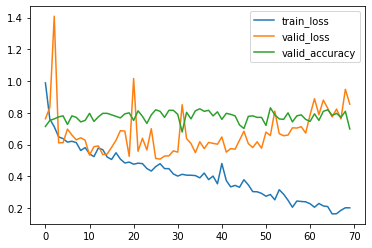

In [61]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [62]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.8107612533546611
TEST
loss: 1.0811201436179025
accuracy: 0.7238095238095238
******************
epoch: 1
Train
0.5914378648503987
TEST
loss: 0.8092504032074459
accuracy: 0.7333333333333333
******************
epoch: 2
Train
0.5287299503685464
TEST
loss: 0.8996675741104853
accuracy: 0.5873015873015873
******************
epoch: 3
Train
0.474100803008053
TEST
loss: 0.62641841173172
accuracy: 0.7682539682539683
******************
epoch: 4
Train
0.4496855656716254
TEST
loss: 0.5651566842245677
accuracy: 0.8
******************
epoch: 5
Train
0.4569604896287108
TEST
loss: 0.8491244372867403
accuracy: 0.7396825396825397
******************
epoch: 6
Train
0.4291237685015696
TEST
loss: 0.915927359036037
accuracy: 0.7238095238095238
******************
epoch: 7
Train
0.41385794845812846
TEST
loss: 0.7126793717581128
accuracy: 0.7555555555555555
******************
epoch: 8
Train
0.3399364919630282
TEST
loss: 0.8938878918450976
accuracy: 0.5968253968253968

In [63]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8527918781725888


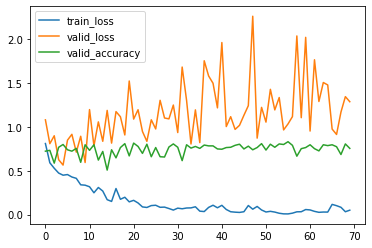

In [64]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [65]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.8694985991342377
TEST
loss: 1.7241083913379245
accuracy: 0.6253968253968254
******************
epoch: 1
Train
0.6559466579019124
TEST
loss: 0.9136781414349874
accuracy: 0.7238095238095238
******************
epoch: 2
Train
0.6367567624242841
TEST
loss: 2.677448269677541
accuracy: 0.4031746031746032
******************
epoch: 3
Train
0.5491571823834804
TEST
loss: 0.6045566019557771
accuracy: 0.7714285714285715
******************
epoch: 4
Train
0.5060963177131792
TEST
loss: 0.5765650474835956
accuracy: 0.7841269841269841
******************
epoch: 5
Train
0.48699023179869694
TEST
loss: 1.3901710232098898
accuracy: 0.7396825396825397
******************
epoch: 6
Train
0.45935954381966987
TEST
loss: 1.074595055882893
accuracy: 0.7841269841269841
******************
epoch: 7
Train
0.450633136761198
TEST
loss: 1.0012555911427452
accuracy: 0.7142857142857143
******************
epoch: 8
Train
0.4368280712056482
TEST
loss: 1.5485472438827395
accuracy: 0

In [66]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8604060913705583


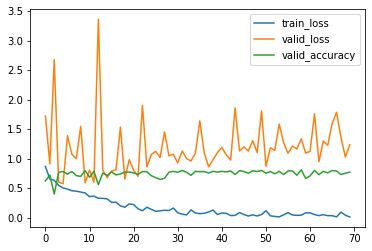

In [67]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [68]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.8195240988534438
TEST
loss: 0.6583052245397416
accuracy: 0.746031746031746
******************
epoch: 1
Train
0.6292180845763969
TEST
loss: 0.6644182753941369
accuracy: 0.7365079365079366
******************
epoch: 2
Train
0.5385450630835639
TEST
loss: 0.9551585012012058
accuracy: 0.653968253968254
******************
epoch: 3
Train
0.5057599232299068
TEST
loss: 2.8315775273338195
accuracy: 0.7365079365079366
******************
epoch: 4
Train
0.5639977192386357
TEST
loss: 1.3035156564107018
accuracy: 0.5142857142857142
******************
epoch: 5
Train
0.5493375449496853
TEST
loss: 0.4988564832816048
accuracy: 0.8222222222222222
******************
epoch: 6
Train
0.48183270247329124
TEST
loss: 0.8339046941863166
accuracy: 0.7492063492063492
******************
epoch: 7
Train
0.4551970740222476
TEST
loss: 0.5352790165515173
accuracy: 0.8063492063492064
******************
epoch: 8
Train
0.39957715039503205
TEST
loss: 1.004055848954216
accuracy: 0

In [69]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.850253807106599


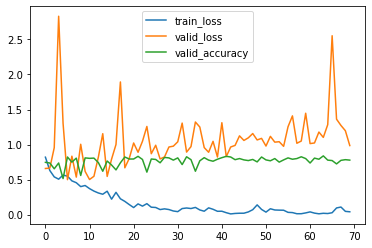

In [70]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [71]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.804427157019319
TEST
loss: 0.7608031393989684
accuracy: 0.7587301587301587
******************
epoch: 1
Train
0.5594031151866421
TEST
loss: 0.8921127629658533
accuracy: 0.7555555555555555
******************
epoch: 2
Train
0.5479585071515242
TEST
loss: 0.6252399985752408
accuracy: 0.7873015873015873
******************
epoch: 3
Train
0.5006257118309557
TEST
loss: 0.6235301513520498
accuracy: 0.7777777777777778
******************
epoch: 4
Train
0.4580491475873376
TEST
loss: 0.6537249171544635
accuracy: 0.7428571428571429
******************
epoch: 5
Train
0.49788101105059396
TEST
loss: 0.6346249436575269
accuracy: 0.7523809523809524
******************
epoch: 6
Train
0.43565211488293504
TEST
loss: 0.6515880737985883
accuracy: 0.7619047619047619
******************
epoch: 7
Train
0.43015482901011887
TEST
loss: 1.2494120276163494
accuracy: 0.6984126984126984
******************
epoch: 8
Train
0.3547762261912215
TEST
loss: 1.4494085540847172
accuracy

In [72]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8045685279187818


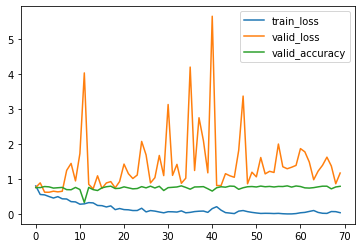

In [73]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [74]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.837792154718146
TEST
loss: 3.231281224508134
accuracy: 0.4222222222222222
******************
epoch: 1
Train
0.6670805190270434
TEST
loss: 0.7419223125018771
accuracy: 0.746031746031746
******************
epoch: 2
Train
0.5938075161624088
TEST
loss: 0.7003621663366045
accuracy: 0.692063492063492
******************
epoch: 3
Train
0.5124590622233057
TEST
loss: 0.8224900890910436
accuracy: 0.7492063492063492
******************
epoch: 4
Train
0.5316906550083963
TEST
loss: 0.6718318405605498
accuracy: 0.7365079365079366
******************
epoch: 5
Train
0.5156414979170768
TEST
loss: 0.5588207278932844
accuracy: 0.8095238095238095
******************
epoch: 6
Train
0.4826628642483682
TEST
loss: 0.6005782583403209
accuracy: 0.7777777777777778
******************
epoch: 7
Train
0.47431398628721927
TEST
loss: 0.6574806851053995
accuracy: 0.765079365079365
******************
epoch: 8
Train
0.4308079109720241
TEST
loss: 1.1867427269617716
accuracy: 0.71

In [75]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8527918781725888


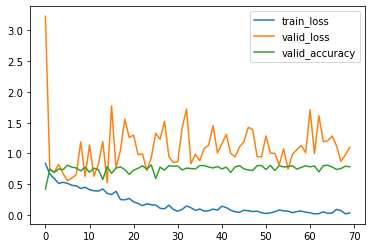

In [76]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [77]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 15
epoch: 0
Train
0.9025689450590453
TEST
loss: 1.244781622621748
accuracy: 0.707936507936508
******************
epoch: 1
Train
0.6741865077976957
TEST
loss: 0.7459689426043677
accuracy: 0.7333333333333333
******************
epoch: 2
Train
0.6613953617283803
TEST
loss: 3.221764143686446
accuracy: 0.29523809523809524
******************
epoch: 3
Train
0.5511290812605993
TEST
loss: 0.5959436936983986
accuracy: 0.7777777777777778
******************
epoch: 4
Train
0.5275138492050201
TEST
loss: 1.0322427155479552
accuracy: 0.5111111111111111
******************
epoch: 5
Train
0.5521396326346469
TEST
loss: 0.5929733605611892
accuracy: 0.780952380952381
******************
epoch: 6
Train
0.5555203749699854
TEST
loss: 0.5982285800434294
accuracy: 0.7873015873015873
******************
epoch: 7
Train
0.5001734448766973
TEST
loss: 0.8316303985459464
accuracy: 0.7619047619047619
******************
epoch: 8
Train
0.47023603170991796
TEST
loss: 0.6443355446770078
accuracy: 0.

In [78]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8350253807106599


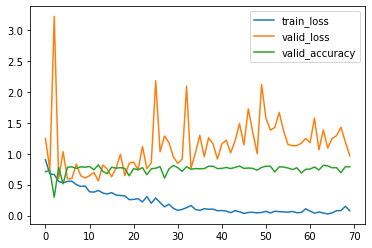

In [79]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()